# Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers

## Project Overview

In my capstone project, I aim to answer 2 main business questions:
1. What are the main drivers of an effective offer on the Starbucks app? 
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer? 

This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.

The provided background information on the mobile app is that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

## Problem Statement

As stated above, the problem statement I am aiming to answer are to (1) discover the main drivers of offer effectiveness, and (2) explore if we can predict whether a user would take up an offer.

The data provided consists of 3 datasets:
- Offer portfolio, which consists of the attributes of each offer
- Demographic data for each customer
- Transactional records of events occurring on the app

Using the data provided, I answer the above two questions using 3 classification supervised machine learning models, feeding in the data from three different offer types. 

I use the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer. 

Lastly, I also explore the characteristics of users who do or do not take up an offer.

My project aims to answer the two questions above, but I also ended up adding 2 additional models as points of exploration - the first assessing whether an all-in-one model could be used in place of 3 different models, with the offer types functioning as a categorical variable. Secondly, I also build a regression model to see if we could predict the amount a user would spend, given that the offer is effectively influencing them.

### Imports & load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Data Exploration

### a. Offer portfolio data

According to the information provided by Udacity, the schema is as follows:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

Moreover, some further information given about the offers is that there are 3 different offer types:
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Thus, the schema is pretty straightforward, as it contains the attributes of 3 different offer types. While the duration was not explained I assumed from context that it is in terms of number of days.

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


The `channels` column consists of nested lists. Hence, I note that I will have to expand the column later during preprocessing to become categorical variables in my dataset. I also note that the scale of each are different, for example the `difficulty` is in terms of dollars while the `duration` is in terms of days. Hence, some feature scaling will need to be done.

In [3]:
#check for null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Good news is that there are no missing values in this dataset, hence we won't have to impute or make any decisions to remove them during the preprocessing stage.

In [4]:
#check no. of unique offers
portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids we will have to take note of, with 4 each of bogo 

*   List item
*   List item

and discount types, while 2 informational types.

### b. Demographic data

Demographic data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It is also relatively straightforward, as it contains the demographic profile on the customer.

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN




```
# This is formatted as code
```

From the first 5 lines we can already see some null values in `gender` and `income`, while the `age` column contains some values that don't make sense (e.g. 118).

In [7]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

As suspected, the `gender` and `income` have null values. Some good news is that whichever values are null in `gender` are also null in `income`. 

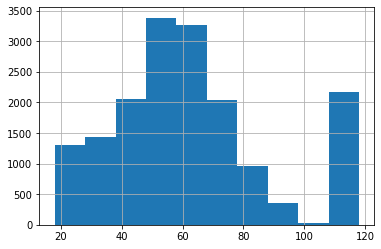

In [9]:
#check distribution of age column
profile.age.hist()

We can see above that the `age = 118` value does not make sense there as it is clearly out of the normal distribution.

In [10]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the `age=118` column corresponds with the null `gender` and `income` columns. Thus, we can actually drop them during preprocessing if they do not take too large a proportion of our data.

In [11]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

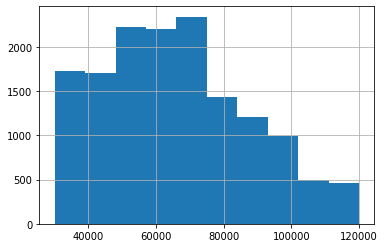

In [12]:
#check distributions of income
profile.income.hist()